# SWB Regression Pipeline - Beta Power 
Created: 07/30/24 \
Updated: 08/22/2024

In [39]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor, LinearRegression


import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
beta_df = pd.read_csv(f'{save_dir}beta_master_df.csv')
beta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [10]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
    roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# # keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# # keep_rois


In [11]:
# ####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(beta_reg_df,reg_formula,elec_col, 
                                                            main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3454.54it/s]


In [14]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [15]:
results = single_elec_permutation_results(results_dict,beta_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.030883,-0.048833,0.024836,0.030278,-0.003525,0.000905,...,0.022253,0.021829,2.074346,-2.074346,1.161166,1.350103,0.038047,0.038047,0.245574,0.176983
1,MS002_lacas2-lacas3,MS002,acc,14,-0.010171,0.017089,0.019667,0.041767,0.001944,-0.000424,...,0.024835,0.026886,-0.655260,0.655260,0.770673,1.528092,0.512300,0.512300,0.440901,0.126490
2,MS002_lacas3-lacas4,MS002,acc,14,0.010854,-0.016153,0.012513,0.045390,-0.001100,0.001127,...,0.023563,0.024569,0.673098,-0.673098,0.539573,1.857015,0.500885,0.500885,0.589492,0.063309
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009645,0.000870,...,0.020837,0.020084,0.744364,-0.744364,-0.366808,2.089910,0.456656,0.456656,0.713762,0.036626
4,MS002_lacas5-lacas6,MS002,acc,14,-0.008841,0.017567,-0.006853,-0.003911,0.004335,-0.001480,...,0.021586,0.021596,-0.834479,0.834479,-0.304314,-0.162865,0.404011,0.404011,0.760889,0.870624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DA039_rpins6-rpins7,DA039,stg,22,-0.000065,-0.004612,0.017953,-0.007242,-0.002209,0.000981,...,0.029244,0.028748,0.192307,-0.192307,0.589923,-0.265701,0.847502,0.847502,0.555242,0.790469
1616,DA039_rpins7-rpins8,DA039,stg,22,0.015836,-0.009086,-0.026308,0.066460,0.012677,-0.000846,...,0.035681,0.035577,0.227831,-0.227831,-0.709087,1.918476,0.819778,0.819778,0.478270,0.055051
1617,DA039_rpins8-rpins9,DA039,stg,22,0.017311,-0.029811,-0.020027,0.022886,0.005696,0.000490,...,0.030728,0.030605,0.991922,-0.991922,-0.650441,0.764899,0.321236,0.321236,0.515408,0.444332
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.123066,0.017559,0.011615,0.056642,-0.117423,0.002839,...,0.048090,0.045758,-0.318853,0.318853,0.251705,1.192260,0.749838,0.749838,0.801269,0.233159


In [16]:
results.columns

Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TotalProfit', 'Original_Estimate_decisionCPE',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TotalProfit', 'Permuted_Mean_decisionCPE',
       'Permuted_Std_Intercept', 'Permuted_Std_GambleChoice[T.safe]',
       'Permuted_Std_TotalProfit', 'Permuted_Std_decisionCPE',
       'Z_Score_Intercept', 'Z_Score_GambleChoice[T.safe]',
       'Z_Score_TotalProfit', 'Z_Score_decisionCPE', 'P_Value_Intercept',
       'P_Value_GambleChoice[T.safe]', 'P_Value_TotalProfit',
       'P_Value_decisionCPE'],
      dtype='object')

In [17]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_beta_{reg_formula}_{date}.pkl',"wb"))

In [18]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009645,0.000870,...,0.020837,0.020084,0.744364,-0.744364,-0.366808,2.089910,0.456656,0.456656,0.713762,0.036626
18,MS002_laims4-laims5,MS002,ains,14,-0.007378,0.047009,0.043292,0.065644,0.025761,-0.000896,...,0.029624,0.030801,-1.444143,1.444143,1.480574,2.174326,0.148699,0.148699,0.138720,0.029681
30,MS002_lhplt9-lhplt10,MS002,sts,14,-0.084193,0.043151,0.057495,-0.065737,-0.053606,-0.001064,...,0.026847,0.026839,-1.484347,1.484347,2.170640,-2.413548,0.137717,0.137717,0.029958,0.015798
59,MS002_racas7-racas8,MS002,dmpfc,14,0.128225,-0.127799,0.014455,-0.067314,0.040515,-0.001009,...,0.031316,0.032128,3.580277,-3.580277,0.442673,-2.070637,0.000343,0.000343,0.658002,0.038393
69,MS002_raims1-raims2,MS002,ains,14,0.112480,-0.115058,0.034586,0.097877,0.031939,0.001368,...,0.040120,0.039646,2.638762,-2.638762,0.867610,2.504184,0.008321,0.008321,0.385608,0.012273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,DA037_rsmg15-rsmg16,DA037,smg,4,-0.029991,-0.068389,0.006691,0.064217,-0.045952,-0.000554,...,0.032062,0.031306,1.761327,-1.761327,0.238285,2.033240,0.078183,0.078183,0.811660,0.042028
1564,DA037_rmins1-rmins2,DA037,pins,4,-0.134143,0.055278,-0.020561,0.089573,-0.120663,-0.002010,...,0.028000,0.028578,-1.765343,1.765343,-0.731702,3.103075,0.077506,0.077506,0.464351,0.001915
1607,DA039_rof9-rof10,DA039,dlpfc,22,-0.086829,0.009231,0.053648,0.091305,-0.083872,0.001518,...,0.041004,0.040522,-0.190659,0.190659,1.279673,2.268526,0.848793,0.848793,0.200660,0.023297
1609,DA039_rof11-rof12,DA039,dlpfc,22,-0.174226,-0.050734,0.006831,0.084149,-0.193323,-0.000914,...,0.044214,0.042279,1.178586,-1.178586,0.150694,2.017351,0.238563,0.238563,0.880217,0.043659


In [30]:
sig_data.roi.value_counts()

acc         23
sts         15
ofc         15
dmpfc       15
dlpfc       12
mtg          9
ains         8
smg          8
stg          7
pins         6
vlpfc        5
hpc          5
amy          4
thalamus     3
Name: roi, dtype: int64

In [20]:
sig_data.roi.unique()

array(['acc', 'ains', 'sts', 'dmpfc', 'dlpfc', 'ofc', 'pins', 'amy',
       'vlpfc', 'hpc', 'stg', 'mtg', 'smg', 'thalamus'], dtype=object)

In [21]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


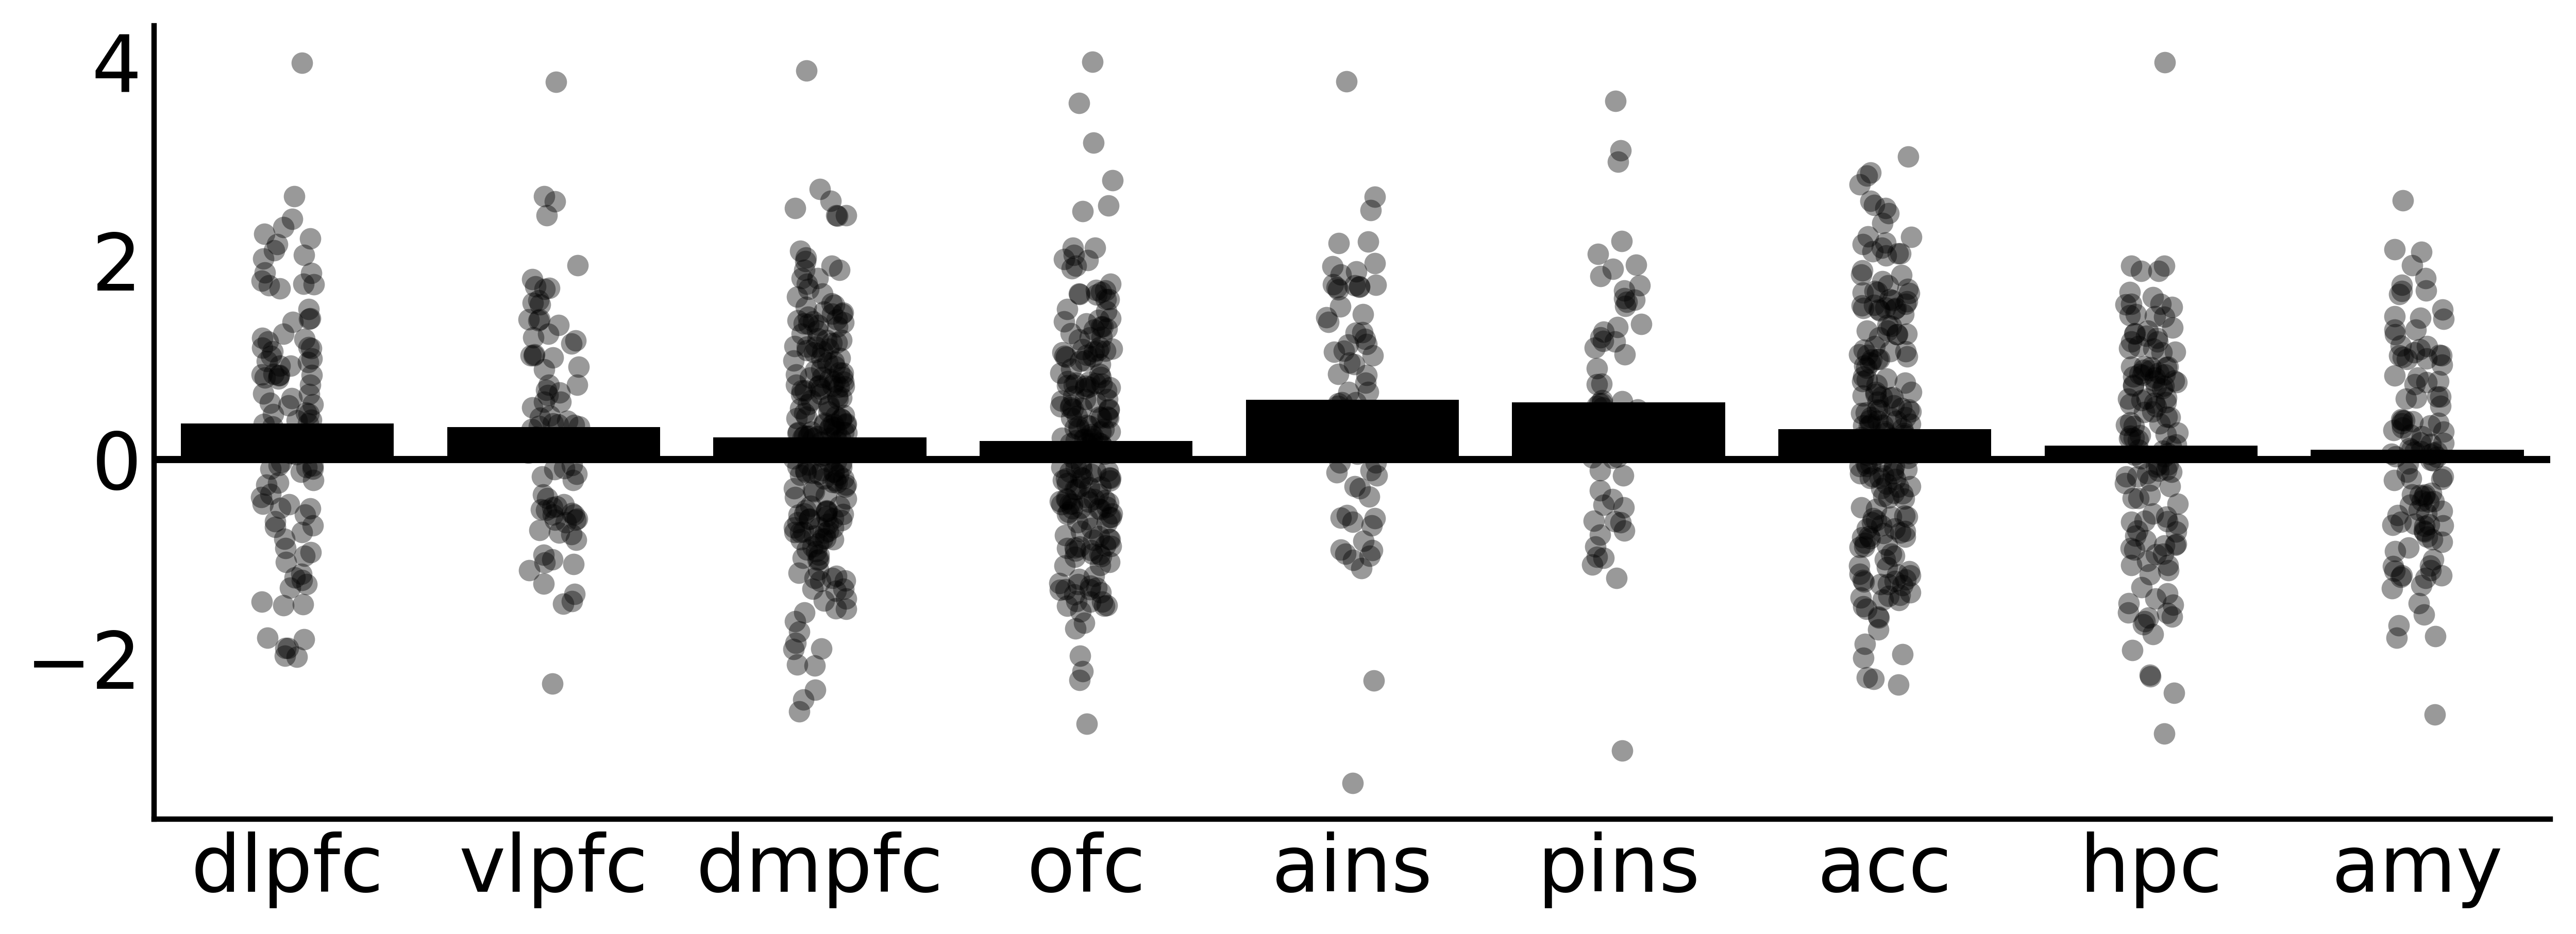

In [22]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='k')
# green '#135546'


In [23]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc    0.362609
vlpfc    0.326169
dmpfc    0.220624
ofc      0.183854
ains     0.597751
pins     0.573406
acc      0.302730
hpc      0.139197
amy      0.098416
Name: Z_Score_decisionCPE, dtype: float64

In [24]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.030883,-0.048833,0.024836,0.030278,-0.003525,0.000905,...,0.022253,0.021829,2.074346,-2.074346,1.161166,1.350103,0.038047,0.038047,0.245574,0.176983
1,MS002_lacas2-lacas3,MS002,acc,14,-0.010171,0.017089,0.019667,0.041767,0.001944,-0.000424,...,0.024835,0.026886,-0.655260,0.655260,0.770673,1.528092,0.512300,0.512300,0.440901,0.126490
2,MS002_lacas3-lacas4,MS002,acc,14,0.010854,-0.016153,0.012513,0.045390,-0.001100,0.001127,...,0.023563,0.024569,0.673098,-0.673098,0.539573,1.857015,0.500885,0.500885,0.589492,0.063309
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009645,0.000870,...,0.020837,0.020084,0.744364,-0.744364,-0.366808,2.089910,0.456656,0.456656,0.713762,0.036626
4,MS002_lacas5-lacas6,MS002,acc,14,-0.008841,0.017567,-0.006853,-0.003911,0.004335,-0.001480,...,0.021586,0.021596,-0.834479,0.834479,-0.304314,-0.162865,0.404011,0.404011,0.760889,0.870624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,DA039_rpins1-rpins2,DA039,pins,22,0.006150,0.000627,-0.006567,0.023253,0.007041,-0.001695,...,0.024734,0.025488,-0.089763,0.089763,-0.207197,0.912195,0.928476,0.928476,0.835856,0.361666
1611,DA039_rpins2-rpins3,DA039,pins,22,0.012924,0.037311,0.002998,0.014782,0.027478,-0.000655,...,0.027580,0.027464,-1.386467,1.386467,0.115568,0.537880,0.165604,0.165604,0.907995,0.590660
1612,DA039_rpins3-rpins4,DA039,pins,22,-0.005030,-0.032606,-0.054730,0.044405,-0.017777,0.000648,...,0.029917,0.030833,1.109138,-1.109138,-1.798247,1.360945,0.267371,0.267371,0.072138,0.173531
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.123066,0.017559,0.011615,0.056642,-0.117423,0.002839,...,0.048090,0.045758,-0.318853,0.318853,0.251705,1.192260,0.749838,0.749838,0.801269,0.233159


In [25]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [26]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.302730
ains,0.597751
amy,0.098416
dlpfc,0.362609
dmpfc,0.220624
hpc,0.139197
ofc,0.183854
pins,0.573406
vlpfc,0.326169


In [53]:
# single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]

,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,0.302730,-0.130569,0.0703
dmpfc,0.220624,-0.024892,0.7160
amy,0.098416,-0.013144,0.8901
ains,0.597751,-0.282013,0.0172
vlpfc,0.326169,-0.277137,0.0117
hpc,0.139197,-0.103410,0.2327
ofc,0.183854,-0.213472,0.0023
pins,0.573406,0.056617,0.6674
dlpfc,0.362609,-0.209934,0.0300


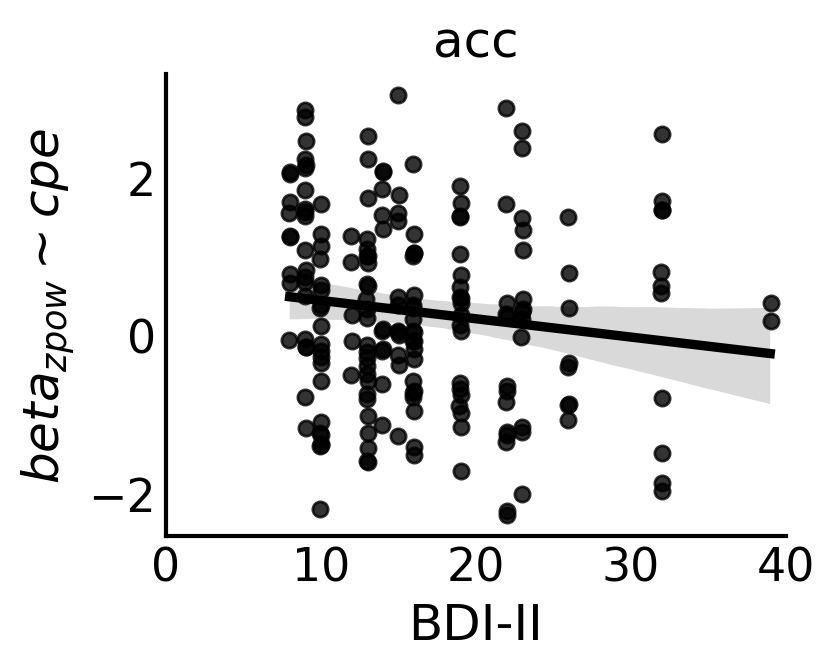

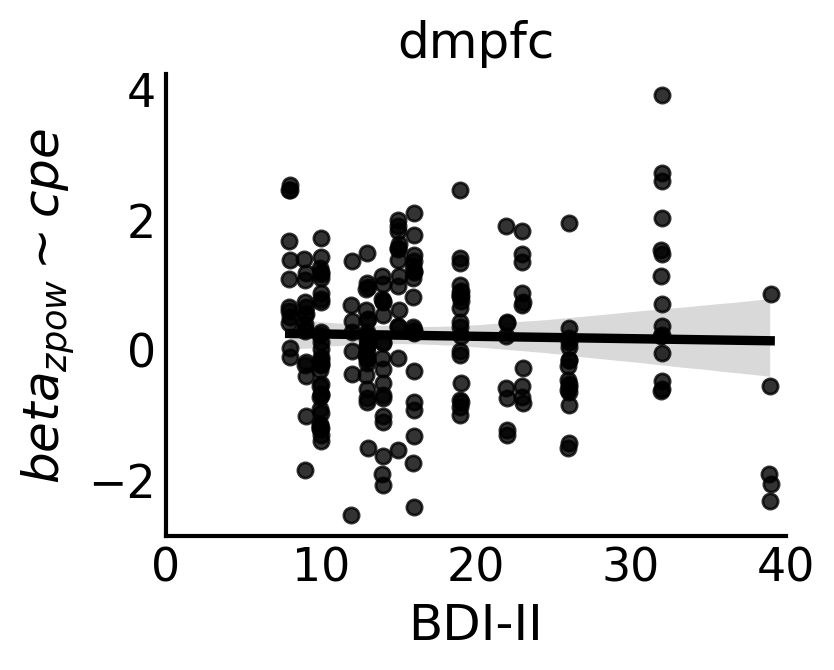

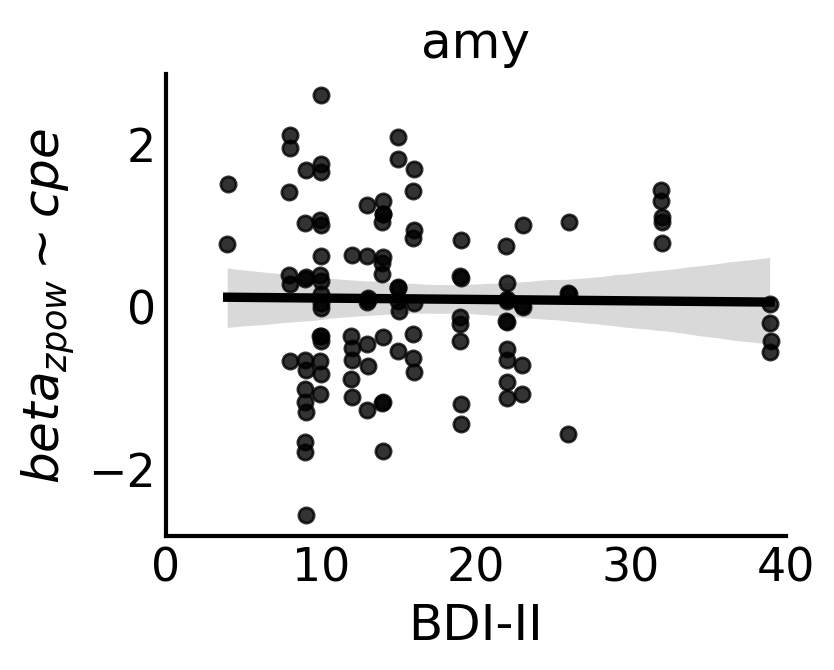

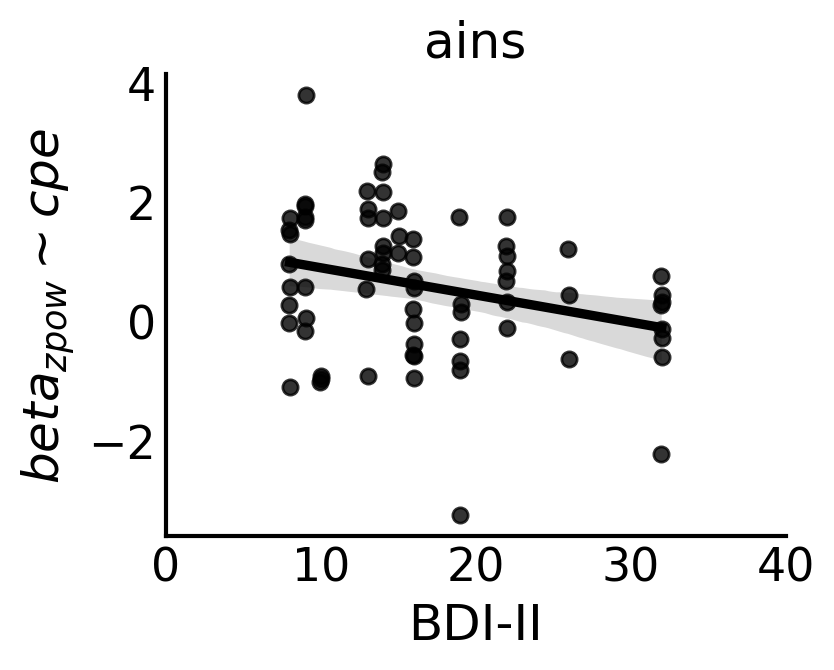

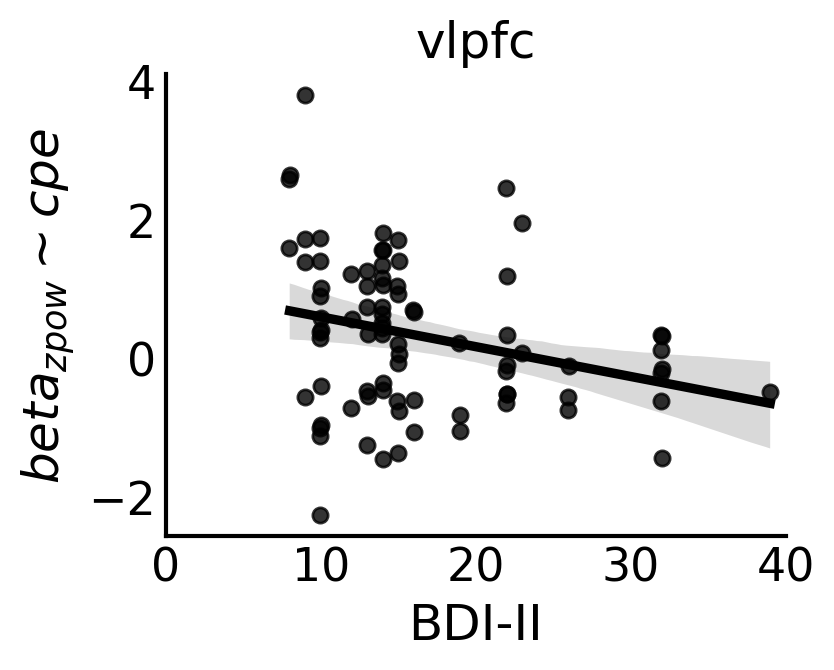

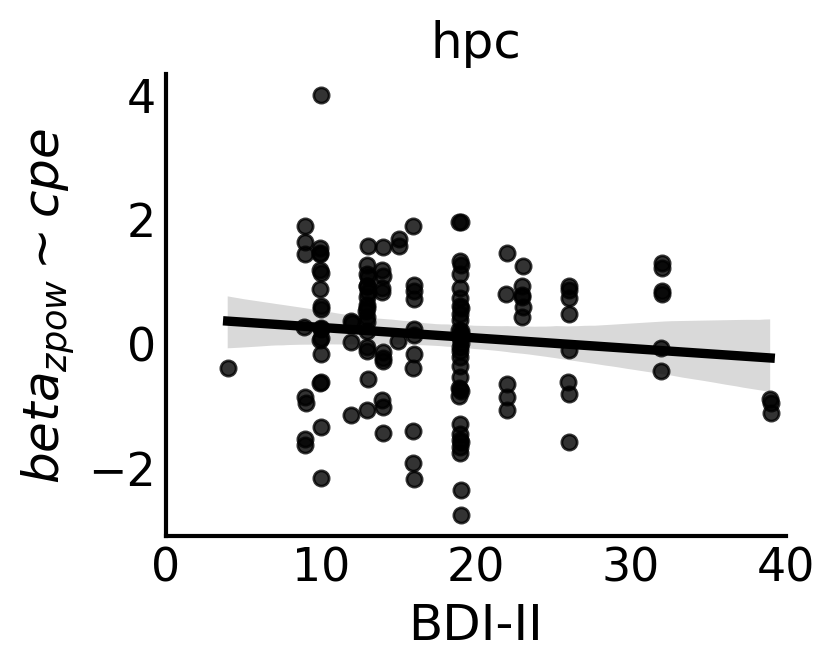

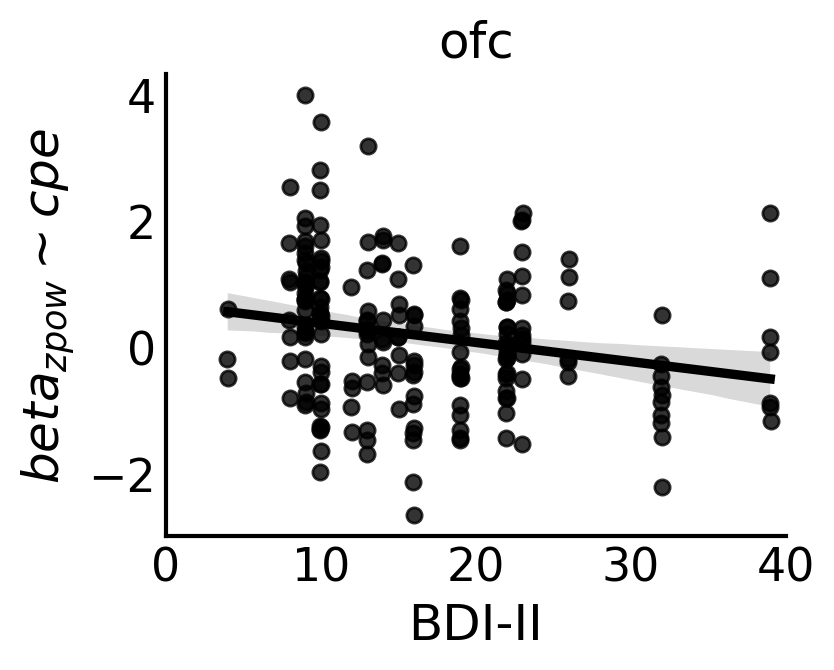

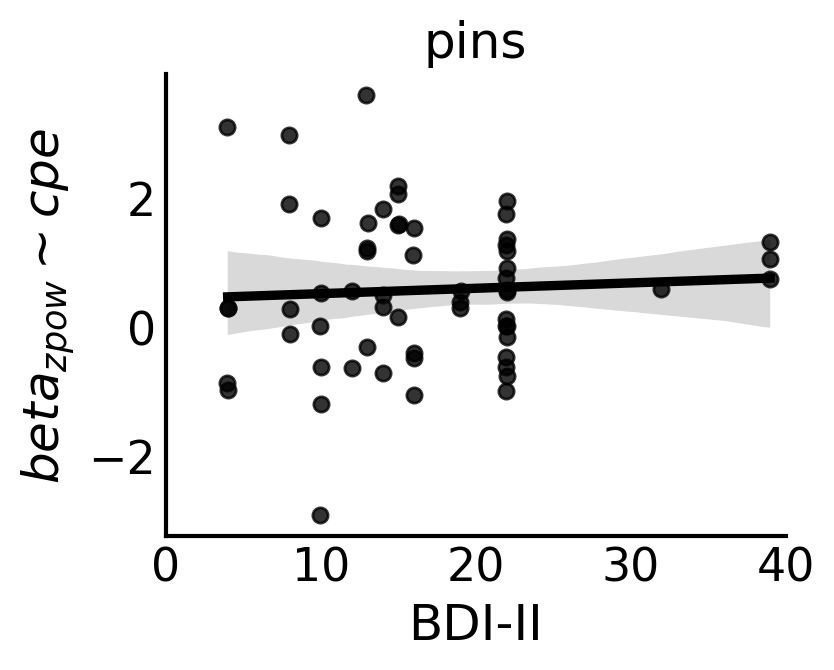

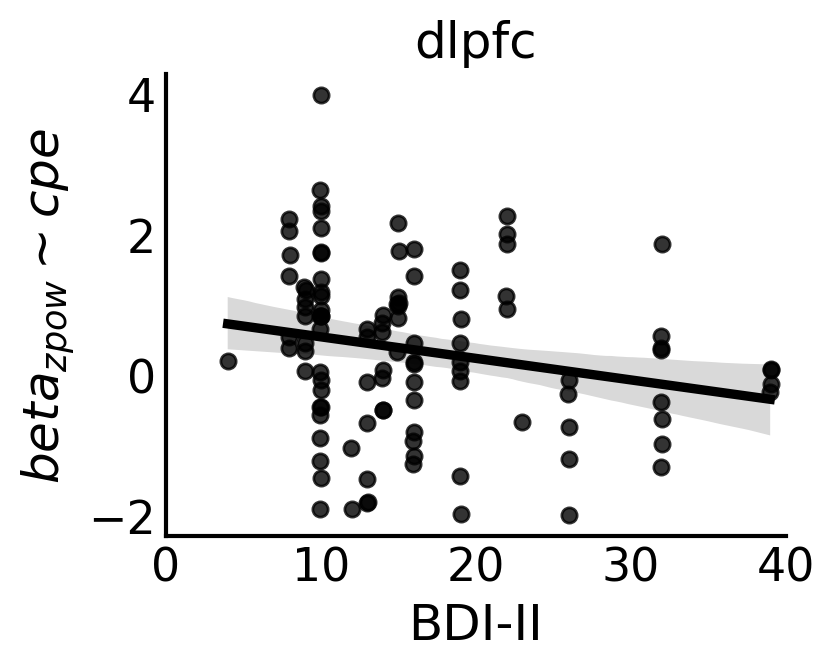

In [29]:
band = 'beta'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()


### Test BDI Correlations via robust regression

In [51]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        11:23:39                                         
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9406      0.447     35.629     

In [42]:
X = roi_df.Z_Score_decisionCPE.values.reshape(-1, 1) 
# X
y = roi_df.bdi.values.reshape(-1, 1) 


In [49]:
rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
rlm_results = rlm.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                            RLM   Df Residuals:                      105
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        11:21:31                                         
No. Iterations:                    36                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5342      0.674     23.050      0.000      14.213      16.855
x1            -1.1941      0.549     -2.175      0.030      -2.270      -0.118
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [47]:
from sklearn.metrics import r2_score, mean_squared_error

# # Create a model 
# model = RANSACRegressor(min_samples=50, max_trials=100000)#, 
# #                         loss='absolute_loss', random_state=42, 
# #                         residual_threshold=10) 
  
# # Fit the model 
# model.fit(X, y) 


# y_pred = model.predict(X) 
# # print(metrics.mean_absolute_error(y, y_pred)) 
# y_pred

R2 = r2_score(y, y_pred)
RMSE = np.sqrt(mean_squared_error(y, y_pred))
print("R^2: {:.3f}, RMSE: {:.3f}".format(R2, RMSE))

R^2: -0.210, RMSE: 8.848


In [ ]:
plt.scatter(y,y_pred)

In [ ]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)
# # Compare estimated coefficients
# print(“Estimated coefficients (true, linear regression, RANSAC):”)
# print(coef, lr.coef_, ransac.estimator_.coef_)

# Mixed effects models

In [60]:
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(bar_order)]
beta_reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123971,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186139,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.235353,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.086471,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145393,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,20.743342,beta,0.219118,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,20.743342,beta,0.080566,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,20.743342,beta,0.204231,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,20.743342,beta,-0.199545,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [61]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [62]:
roi_fit_dict = {f'{roi}':fit_mixed_model(beta_reg_df[beta_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in beta_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],beta_reg_df[beta_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [69]:
roi_fit_results['band'] = 'beta'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=25.15983042995267, pvalue=1.0790652673721144e-62, df=192),
 'dmpfc': TtestResult(statistic=11.214186629091538, pvalue=2.8022002371023047e-23, df=215),
 'amy': TtestResult(statistic=-1.5512443809593819, pvalue=0.12366434870239791, df=112),
 'ains': TtestResult(statistic=38.158698175761174, pvalue=1.3832802599846608e-48, df=70),
 'vlpfc': TtestResult(statistic=28.088613889770517, pvalue=1.6246464794522154e-43, df=81),
 'hpc': TtestResult(statistic=8.378290826945442, pvalue=6.40380913844168e-14, df=134),
 'ofc': TtestResult(statistic=42.04920276078307, pvalue=1.477222334268924e-101, df=201),
 'pins': TtestResult(statistic=8.22890680049308, pvalue=2.2462572082490342e-11, df=59),
 'dlpfc': TtestResult(statistic=15.199177593043716, pvalue=2.209239020246355e-28, df=106)}

In [63]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,0.007723,-0.013800,0.004556,0.001196,0.017020,-0.000858,-0.000608,acc,0.0043,0.0012,0.0738
1,-0.031915,-0.008017,0.006599,0.010465,0.009212,-0.000409,-0.000119,dmpfc,0.1675,0.5536,0.7483
2,-0.077182,0.008994,0.000278,0.011262,-0.001063,-0.000840,0.000196,amy,0.9330,0.6980,0.7955
3,0.061131,-0.016248,-0.021374,0.009931,0.061766,-0.001848,-0.002251,ains,0.0000,0.0190,0.0053
4,0.003940,-0.013510,-0.010860,0.005658,0.040533,-0.001722,-0.001662,vlpfc,0.0001,0.0383,0.0046
5,-0.188515,0.007712,-0.002708,-0.005739,0.012162,0.003992,-0.000637,hpc,0.3305,0.0705,0.3608
6,0.021404,0.000446,-0.049642,0.004967,0.026380,-0.002604,-0.001190,ofc,0.0000,0.0158,0.0003
7,-0.056432,0.003965,-0.013023,0.002661,0.022169,0.000255,-0.000155,pins,0.0716,0.9036,0.8169
8,-0.030595,-0.010656,0.011508,0.012675,0.026423,-0.001045,-0.000915,dlpfc,0.0013,0.0946,0.0428


In [64]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [65]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

['acc', 'ains', 'vlpfc', 'ofc', 'dlpfc']

In [66]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois

['ains', 'vlpfc', 'ofc']

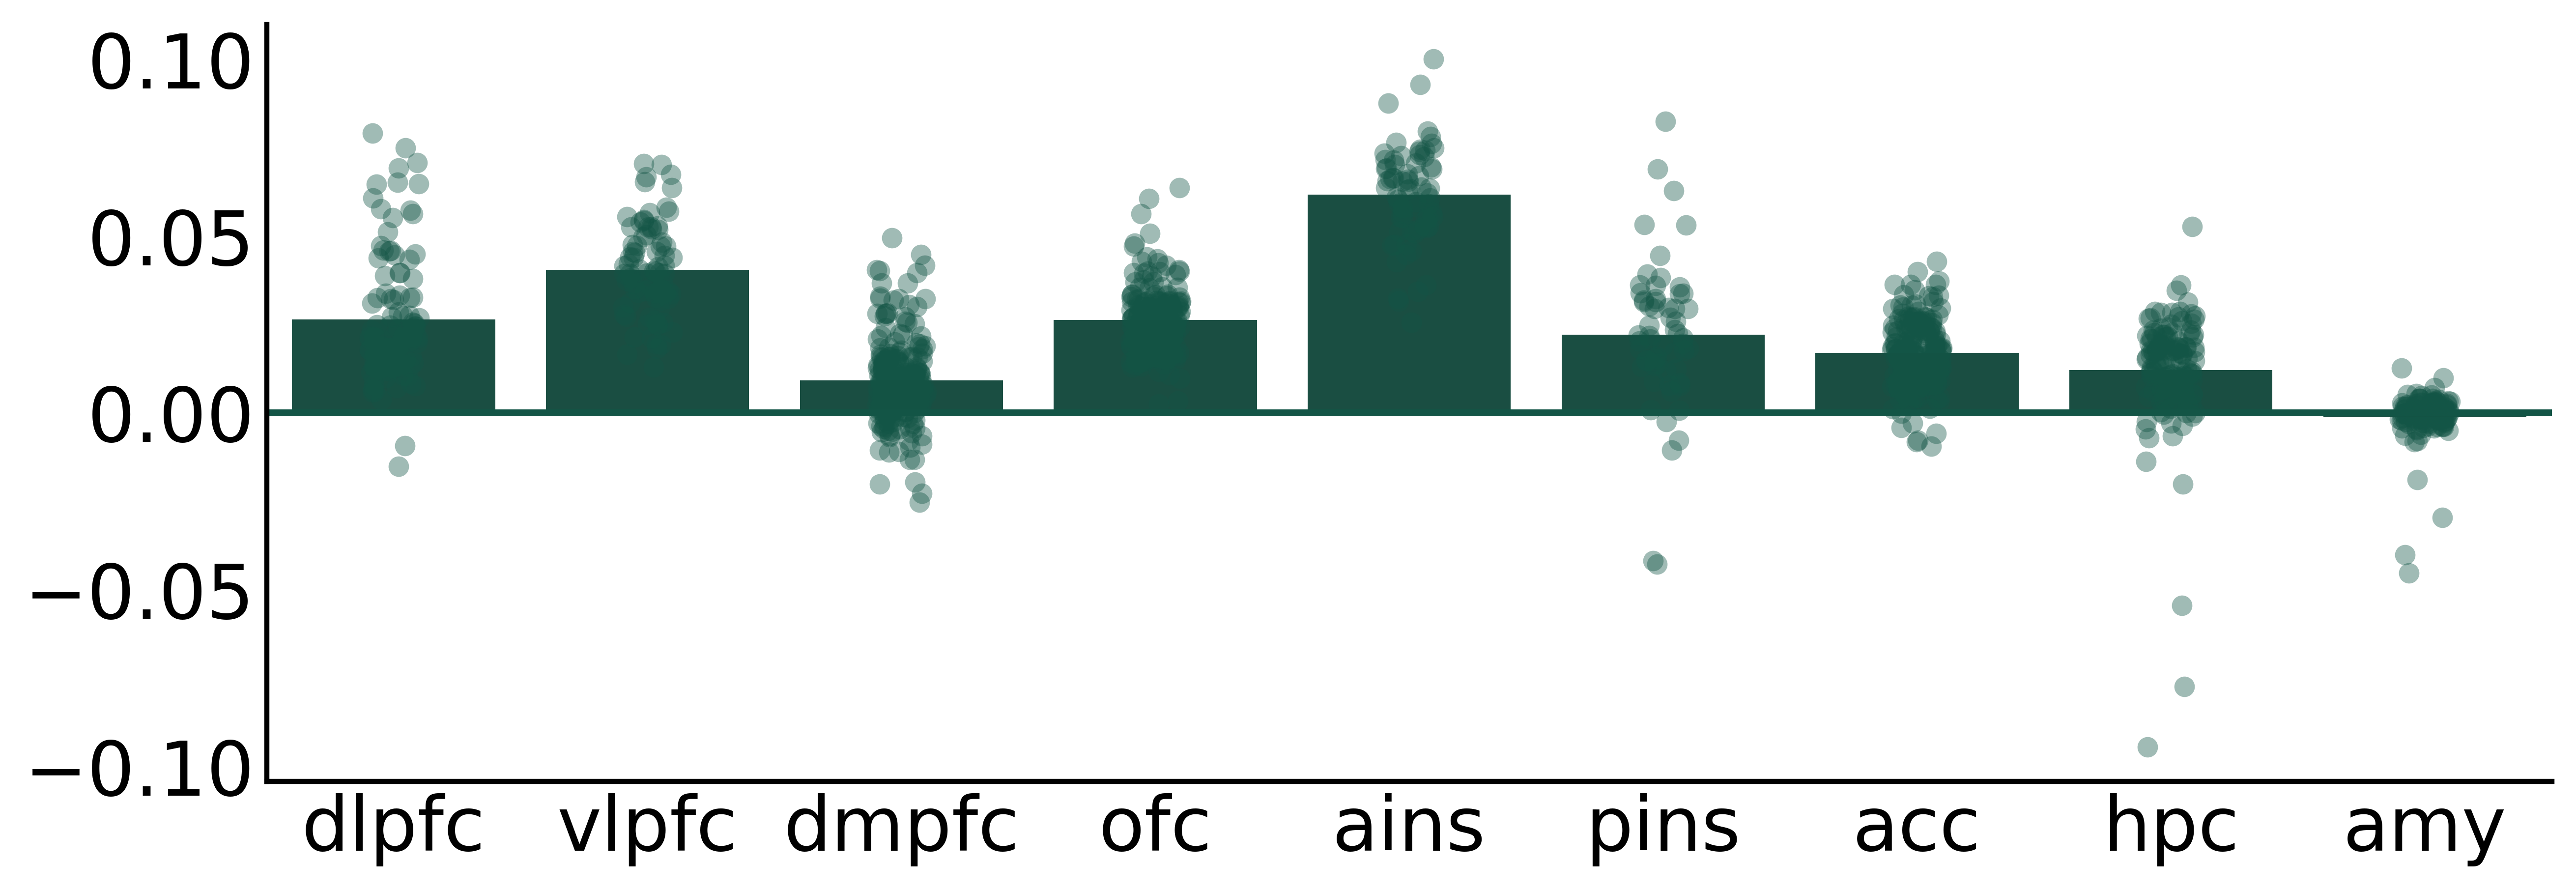

In [67]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#135546')


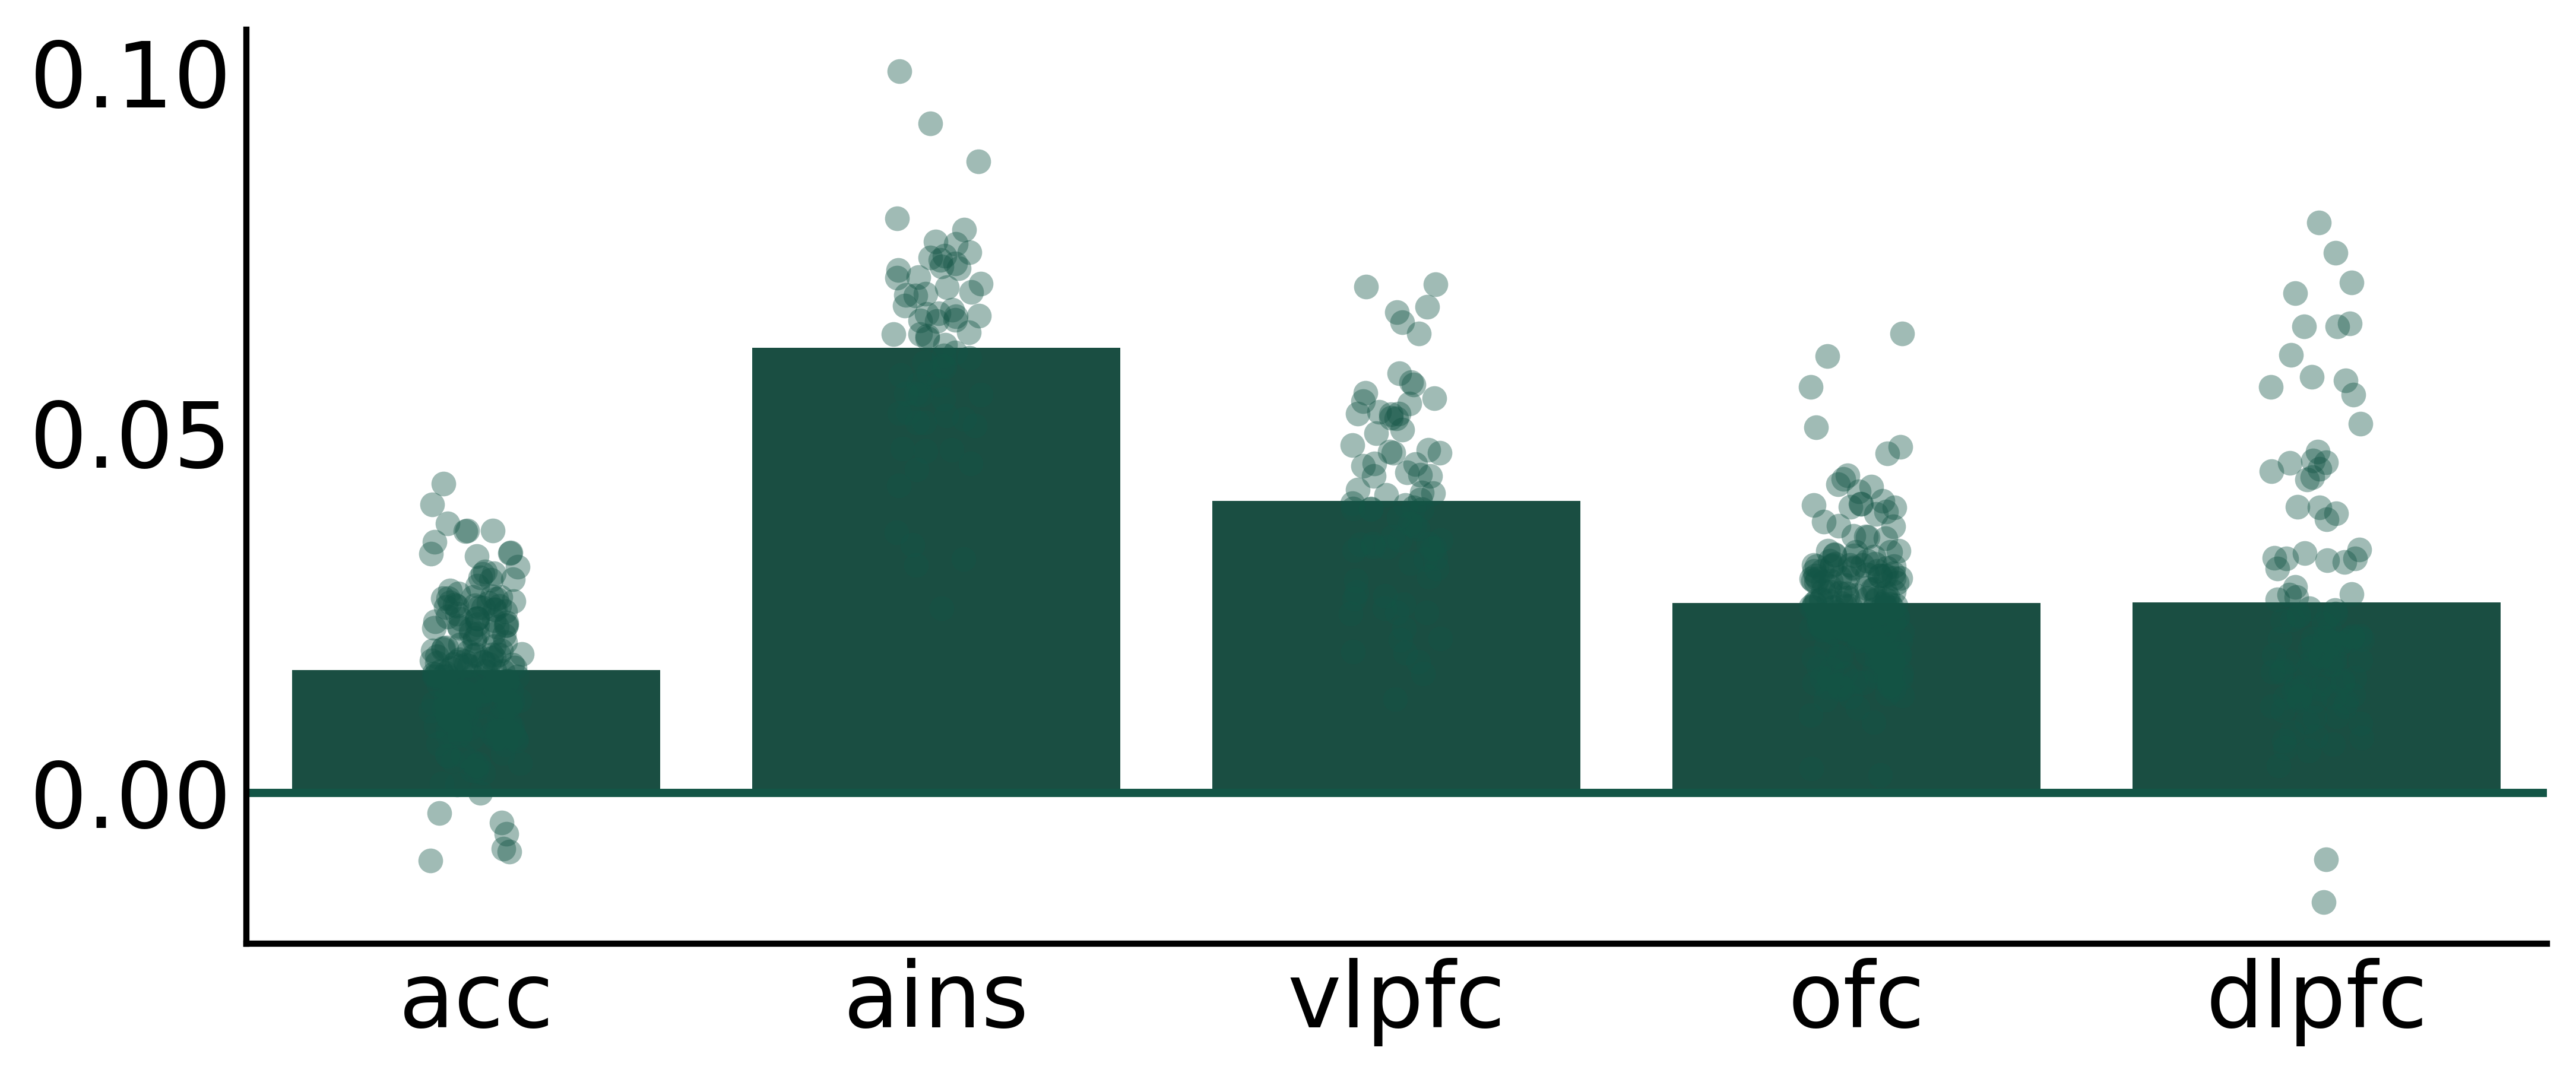

In [68]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois,color='#135546')


# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')
# sns.despine()


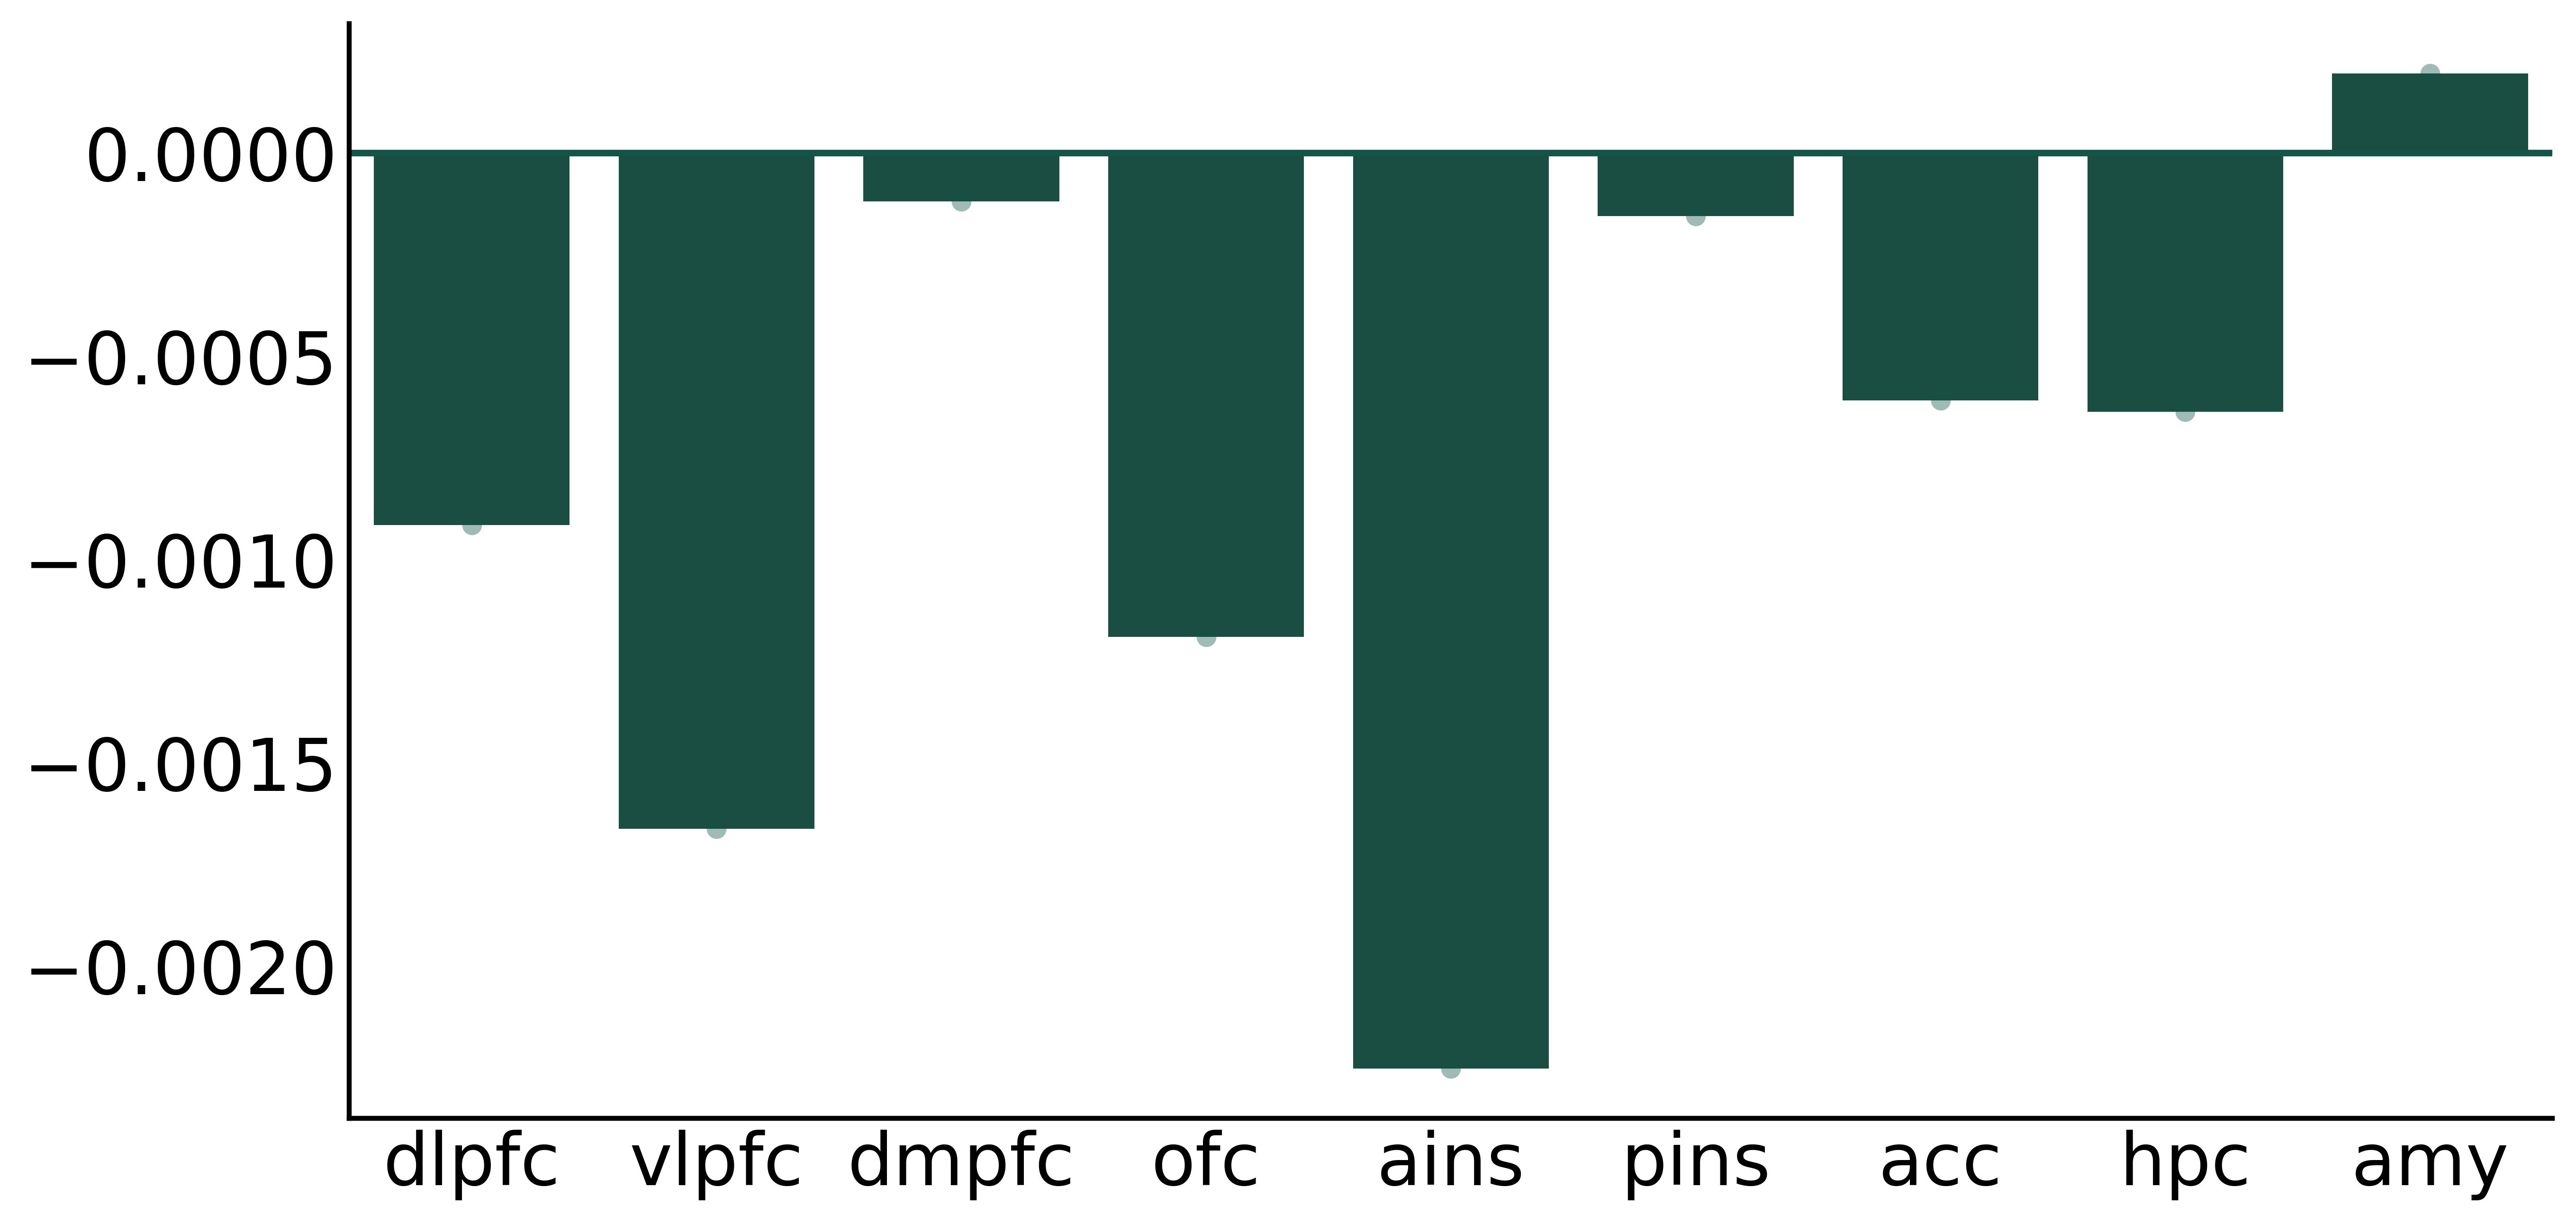

In [70]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#135546')
# add to slides 
